In [9]:
# Utils
import time
import cv2
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
from keras.metrics import Precision, Recall

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Dropout, Lambda, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import model_from_json

In [11]:
def extractImages(datapoints):
  # Reshape sequences to images  
  width, height = 48, 48

  #getting features for training
  X = []
  for sequence in datapoints:
    pixels = [int(p) for p in sequence.split(' ')]
    pixels = np.asarray(pixels).reshape(width, height)
    X.append(pixels.astype('float32'))

  X = np.asarray(X)
  X = np.expand_dims(X, -1)
  return X

def load_data():
  # load the data from Google Drive into a Pandas DataFrame
  data = pd.read_excel("E:\\final edits\\fer+affect.xlsx")

  # Isolate the features (X) and the corresponding emotion labels (Y)
  X = data.loc[:, 'pixels']
  Y = data.loc[:, 'emotion_label']

  # Get NumPy arrays for each of the predefined splits of X and Y
  x_train = X.loc[data['Usage'] == 'Train'].values
  x_val =  X.loc[data['Usage'] == 'validate'].values
  x_test =  X.loc[data['Usage'] == 'test'].values

  y_train = Y.loc[data['Usage'] == 'Train'].values
  y_val =  Y.loc[data['Usage'] == 'validate'].values
  y_test =  Y.loc[data['Usage'] == 'test'].values
  
  #getting labels for training
  y_train = pd.get_dummies(y_train).values
  y_val = pd.get_dummies(y_val).values
  y_test = pd.get_dummies(y_test).values

  # Reshape to image
  x_train = extractImages(x_train)
  x_val = extractImages(x_val)
  x_test = extractImages(x_test)

  # Standardization
  train_mean = np.mean(x_train, axis=0)
  train_std = np.std(x_train, axis=0)

  x_train = (x_train - train_mean) / train_std
  x_val = (x_val - train_mean) / train_std
  x_test = (x_test - train_mean) / train_std


  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

  

(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_FER13()

In [12]:
# Just in case we need it
def PermaDropout(rate): # insures usage of dropout in evaluation (tf disables normal dropout in testing by default)
    return Lambda(lambda x: tf.keras.backend.dropout(x, level=rate))

def buildModel(activation_function='relu', padding='same', kernel_sizes=[(3,3)], filters=(8, 12), 
                pooling_kernels = [(2,2)], dilation_rate = (1,1), strides = (1,1), 
                input_shape=(48, 48, 1), dense_units=[], output_classes=7, dropout_rate=0):
    """
        function that builds a CNN model with an architecture specified in its parameters.
    
    """
    assert len(kernel_sizes) == len(filters), "Please make sure you define a kernel size for every ConvLayer"
    #input_shape: 48 x 48 pixels with 1 color channel?

    model = Sequential() # using a sequential architecture
    # Feature Extractor (CNN part)
    for i in range(len(filters)):    
        if i == 0:
            # input layer
            model.add(Conv2D(
                activation=activation_function,
                filters=filters[i],
                kernel_size=kernel_sizes[i],
                padding=padding,
                strides=strides,
                data_format='channels_last',
                dilation_rate=dilation_rate, # dilation only used in first layer for now
                input_shape=input_shape))
        else:
          # Hidden Layers
          model.add(Conv2D(
              activation=activation_function,
              filters=filters[i],
              kernel_size=kernel_sizes[i],
              padding=padding,
              strides=strides
              )
          )
          
          model.add(BatchNormalization())

        if i < len(pooling_kernels):
            model.add(MaxPooling2D(pooling_kernels[i]))
    
        if dropout_rate is not None and dropout_rate != 0:
            model.add(PermaDropout(dropout_rate))

    # ANN part (Classifier)
    model.add(Flatten())
    for units in dense_units:
        model.add(Dense(units, activation=activation_function))

        if dropout_rate is not None and dropout_rate != 0:
            model.add(PermaDropout(dropout_rate))
    # ouput prediction of 7 class probabilities
    model.add(Dense(output_classes, activation='softmax'))
    return model

In [13]:
def compileModel(model, initial_lr, lr_decay):

    # Learning rate handling
    if lr_decay == 1:
        lr_schedule = initial_lr    
    else:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_lr, decay_steps=16, decay_rate=lr_decay, staircase=True)
    opt = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
def runtest(model, epochs, batchsize, model_name=''):
    # unpack data
    # just using global variables...
    # (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_data()

    start_time = time.time()
    callbacks_list = []#[ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)]

    callbacks_list.append(
    tf.keras.callbacks.ModelCheckpoint(
            'checkpoint.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=False,
            save_freq='epoch', verbose=0
        )
    )
        
    print("train_data.shape=", len(x_train), len(y_train))
    print("batchsize=", batchsize)
    print("epochs=", epochs)

    # history = model.fit(x=x_train, y=y_train,
    #                     batch_size=batchsize,
    #                     epochs=epochs, # Iterations are epochs <- better for plotting... smaller steps
    #                     validation_data=(x_val, y_val),
    #                     callbacks=callbacks_list,
    #                     shuffle=True)
    
    history = model.fit(x=x_train, y=y_train,
                        batch_size=batchsize,
                        epochs=epochs, # Iterations are epochs <- better for plotting... smaller steps
                        validation_data=(x_val, y_val),
                        callbacks=callbacks_list,
                        shuffle=True)

    print("Evaluate on test data")
    model.evaluate(x=x_test, y=y_test, batch_size=batchsize)

    print("--- %s seconds ---" % (time.time() - start_time))

    np.save(model_name +'_history.npy',history.history)
    model.save(model_name + '.h5') # around 395 mb...

    return history

In [15]:
### HYPERPARAMETERS
learning_rate = 1e-4
lr_decay = 1
L2_reg_rate = 0
batchsize = 64
epochs = 40
initial = 64
layers = 4

test_set = [(2, 2)] 
histories = []

for dilationrate in test_set:
    kernelsizes = [(3, 3) for i in range(layers)]
    pooling = [(2, 2) for i in range(3)]
    
    filterunits = [initial * pow(2, i) for i in range(len(kernelsizes))]
    dense = [filterunits[-1], filterunits[-2]] # same as last conv filtercount

    model_name = 'Output'

    model = buildModel(activation_function='relu', padding='same', kernel_sizes=kernelsizes,
                       filters=filterunits, pooling_kernels=pooling, dilation_rate=dilationrate,
                       strides=(1, 1), input_shape=(48, 48, 1), dense_units=dense, output_classes=7,
                       dropout_rate=0.25)

    model = compileModel(model, learning_rate, lr_decay)
    model.summary()
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, dpi=96)
from IPython.display import Image

Image("model.png")

from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(
    model, 
    to_file="model_tree.png", 
    show_shapes=True, 
    show_layer_names=True, 
    rankdir="TB",  # 'TB' for a top-down tree, 'LR' for left-to-right
    dpi=96
)

Image("model_tree.png")
    
    # Train
histories.append(runtest(model, epochs, batchsize, model_name))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_9 (Lambda)               │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_10 (Lambda)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_11 (Lambda)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,124,231 (42.44 MB)

 Trainable params: 11,122,439 (42.43 MB)

 Non-trainable params: 1,792 (7.00 KB)

train_data.shape= 13308 13308
batchsize= 64
epochs= 40
Epoch 1/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.1971 - loss: 2.1992

208/208 ━━━━━━━━━━━━━━━━━━━━ 121s 567ms/step - accuracy: 0.1972 - loss: 2.1984 - val_accuracy: 0.1595 - val_loss: 2.4924
Epoch 2/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.2675 - loss: 1.8398

208/208 ━━━━━━━━━━━━━━━━━━━━ 125s 603ms/step - accuracy: 0.2676 - loss: 1.8397 - val_accuracy: 0.2297 - val_loss: 2.0818
Epoch 3/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.3134 - loss: 1.7466

208/208 ━━━━━━━━━━━━━━━━━━━━ 120s 576ms/step - accuracy: 0.3133 - loss: 1.7466 - val_accuracy: 0.3245 - val_loss: 1.7172
Epoch 4/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.3330 - loss: 1.6871

208/208 ━━━━━━━━━━━━━━━━━━━━ 117s 561ms/step - accuracy: 0.3330 - loss: 1.6870 - val_accuracy: 0.3605 - val_loss: 1.6357
Epoch 5/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.3702 - loss: 1.6242

208/208 ━━━━━━━━━━━━━━━━━━━━ 119s 573ms/step - accuracy: 0.3703 - loss: 1.6242 - val_accuracy: 0.3927 - val_loss: 1.5604
Epoch 6/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.3888 - loss: 1.5501

208/208 ━━━━━━━━━━━━━━━━━━━━ 117s 564ms/step - accuracy: 0.3888 - loss: 1.5501 - val_accuracy: 0.4264 - val_loss: 1.4895
Epoch 7/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4275 - loss: 1.4899

208/208 ━━━━━━━━━━━━━━━━━━━━ 117s 561ms/step - accuracy: 0.4275 - loss: 1.4899 - val_accuracy: 0.4359 - val_loss: 1.4451
Epoch 8/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.4490 - loss: 1.4278

208/208 ━━━━━━━━━━━━━━━━━━━━ 117s 562ms/step - accuracy: 0.4490 - loss: 1.4278 - val_accuracy: 0.4687 - val_loss: 1.3735
Epoch 9/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.4760 - loss: 1.3571

208/208 ━━━━━━━━━━━━━━━━━━━━ 118s 568ms/step - accuracy: 0.4760 - loss: 1.3571 - val_accuracy: 0.4945 - val_loss: 1.3101
Epoch 10/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.5031 - loss: 1.2881

208/208 ━━━━━━━━━━━━━━━━━━━━ 118s 568ms/step - accuracy: 0.5031 - loss: 1.2882 - val_accuracy: 0.5284 - val_loss: 1.2418
Epoch 11/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.5221 - loss: 1.2427

208/208 ━━━━━━━━━━━━━━━━━━━━ 117s 565ms/step - accuracy: 0.5221 - loss: 1.2427 - val_accuracy: 0.5447 - val_loss: 1.1876
Epoch 12/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.5552 - loss: 1.1634

208/208 ━━━━━━━━━━━━━━━━━━━━ 117s 565ms/step - accuracy: 0.5552 - loss: 1.1635 - val_accuracy: 0.5754 - val_loss: 1.1256
Epoch 13/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5830 - loss: 1.0981

208/208 ━━━━━━━━━━━━━━━━━━━━ 113s 546ms/step - accuracy: 0.5830 - loss: 1.0982 - val_accuracy: 0.5965 - val_loss: 1.0620
Epoch 14/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.6115 - loss: 1.0335

208/208 ━━━━━━━━━━━━━━━━━━━━ 117s 563ms/step - accuracy: 0.6114 - loss: 1.0336 - val_accuracy: 0.6274 - val_loss: 0.9896
Epoch 15/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6272 - loss: 0.9843

208/208 ━━━━━━━━━━━━━━━━━━━━ 117s 563ms/step - accuracy: 0.6271 - loss: 0.9843 - val_accuracy: 0.6474 - val_loss: 0.9279
Epoch 16/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6595 - loss: 0.9077

208/208 ━━━━━━━━━━━━━━━━━━━━ 121s 583ms/step - accuracy: 0.6595 - loss: 0.9078 - val_accuracy: 0.6719 - val_loss: 0.8801
Epoch 17/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.6812 - loss: 0.8387

208/208 ━━━━━━━━━━━━━━━━━━━━ 120s 577ms/step - accuracy: 0.6812 - loss: 0.8388 - val_accuracy: 0.7049 - val_loss: 0.8055
Epoch 18/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7028 - loss: 0.7853

208/208 ━━━━━━━━━━━━━━━━━━━━ 123s 592ms/step - accuracy: 0.7028 - loss: 0.7854 - val_accuracy: 0.7301 - val_loss: 0.7464
Epoch 19/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7362 - loss: 0.7141

208/208 ━━━━━━━━━━━━━━━━━━━━ 124s 597ms/step - accuracy: 0.7361 - loss: 0.7142 - val_accuracy: 0.7528 - val_loss: 0.6863
Epoch 20/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.7652 - loss: 0.6481

208/208 ━━━━━━━━━━━━━━━━━━━━ 124s 599ms/step - accuracy: 0.7652 - loss: 0.6482 - val_accuracy: 0.7758 - val_loss: 0.6335
Epoch 21/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7962 - loss: 0.5673

208/208 ━━━━━━━━━━━━━━━━━━━━ 100s 480ms/step - accuracy: 0.7961 - loss: 0.5674 - val_accuracy: 0.7975 - val_loss: 0.5862
Epoch 22/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8071 - loss: 0.5257

208/208 ━━━━━━━━━━━━━━━━━━━━ 100s 480ms/step - accuracy: 0.8071 - loss: 0.5258 - val_accuracy: 0.8201 - val_loss: 0.5331
Epoch 23/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8297 - loss: 0.4764

208/208 ━━━━━━━━━━━━━━━━━━━━ 97s 469ms/step - accuracy: 0.8297 - loss: 0.4764 - val_accuracy: 0.8316 - val_loss: 0.4929
Epoch 24/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8564 - loss: 0.4092

208/208 ━━━━━━━━━━━━━━━━━━━━ 98s 473ms/step - accuracy: 0.8563 - loss: 0.4093 - val_accuracy: 0.8537 - val_loss: 0.4488
Epoch 25/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.8700 - loss: 0.3682

208/208 ━━━━━━━━━━━━━━━━━━━━ 101s 487ms/step - accuracy: 0.8700 - loss: 0.3683 - val_accuracy: 0.8608 - val_loss: 0.4209
Epoch 26/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.8835 - loss: 0.3295

208/208 ━━━━━━━━━━━━━━━━━━━━ 120s 580ms/step - accuracy: 0.8835 - loss: 0.3295 - val_accuracy: 0.8735 - val_loss: 0.3955
Epoch 27/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8973 - loss: 0.2983

208/208 ━━━━━━━━━━━━━━━━━━━━ 109s 523ms/step - accuracy: 0.8973 - loss: 0.2983 - val_accuracy: 0.8854 - val_loss: 0.3745
Epoch 28/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9117 - loss: 0.2615

208/208 ━━━━━━━━━━━━━━━━━━━━ 118s 570ms/step - accuracy: 0.9116 - loss: 0.2616 - val_accuracy: 0.8939 - val_loss: 0.3456
Epoch 29/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9163 - loss: 0.2494

208/208 ━━━━━━━━━━━━━━━━━━━━ 114s 550ms/step - accuracy: 0.9163 - loss: 0.2494 - val_accuracy: 0.9022 - val_loss: 0.3335
Epoch 30/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 105s 504ms/step - accuracy: 0.9261 - loss: 0.2199 - val_accuracy: 0.9024 - val_loss: 0.3397
Epoch 31/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.9333 - loss: 0.1988

208/208 ━━━━━━━━━━━━━━━━━━━━ 123s 594ms/step - accuracy: 0.9333 - loss: 0.1988 - val_accuracy: 0.9133 - val_loss: 0.3076
Epoch 32/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 121s 580ms/step - accuracy: 0.9409 - loss: 0.1814 - val_accuracy: 0.9107 - val_loss: 0.3142
Epoch 33/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9415 - loss: 0.1735

208/208 ━━━━━━━━━━━━━━━━━━━━ 123s 593ms/step - accuracy: 0.9415 - loss: 0.1735 - val_accuracy: 0.9176 - val_loss: 0.3050
Epoch 34/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9500 - loss: 0.1507

208/208 ━━━━━━━━━━━━━━━━━━━━ 118s 568ms/step - accuracy: 0.9500 - loss: 0.1508 - val_accuracy: 0.9208 - val_loss: 0.3014
Epoch 35/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9506 - loss: 0.1465

208/208 ━━━━━━━━━━━━━━━━━━━━ 124s 595ms/step - accuracy: 0.9506 - loss: 0.1465 - val_accuracy: 0.9236 - val_loss: 0.2860
Epoch 36/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 117s 562ms/step - accuracy: 0.9534 - loss: 0.1392 - val_accuracy: 0.9275 - val_loss: 0.2861
Epoch 37/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 112s 539ms/step - accuracy: 0.9606 - loss: 0.1217 - val_accuracy: 0.9240 - val_loss: 0.2997
Epoch 38/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9639 - loss: 0.1179

208/208 ━━━━━━━━━━━━━━━━━━━━ 99s 474ms/step - accuracy: 0.9639 - loss: 0.1180 - val_accuracy: 0.9310 - val_loss: 0.2765
Epoch 39/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 95s 457ms/step - accuracy: 0.9614 - loss: 0.1181 - val_accuracy: 0.9295 - val_loss: 0.2906
Epoch 40/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9637 - loss: 0.1126

208/208 ━━━━━━━━━━━━━━━━━━━━ 99s 475ms/step - accuracy: 0.9637 - loss: 0.1127 - val_accuracy: 0.9324 - val_loss: 0.2761
Evaluate on test data
73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.9694 - loss: 0.0977


--- 4583.625004291534 seconds ---


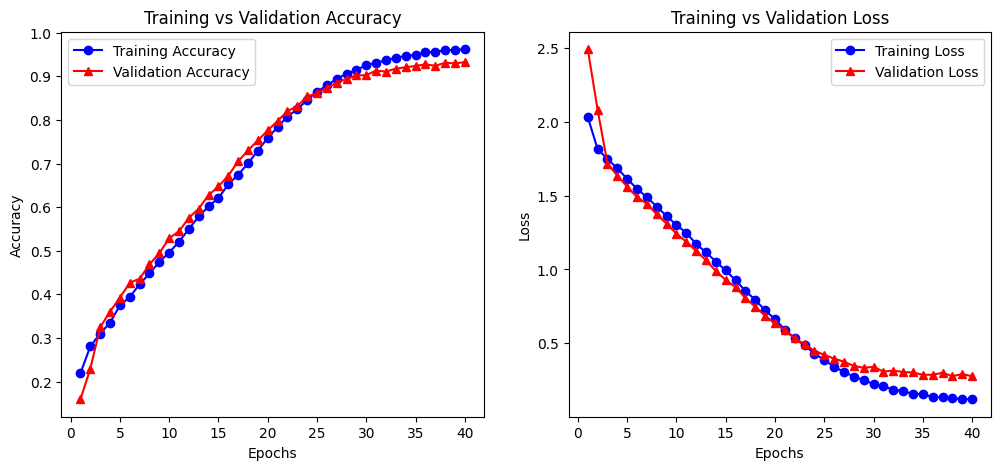

In [16]:
import matplotlib.pyplot as plt

# Function to plot Accuracy & Loss Graphs
def plot_training_history(history):
    # Extract values from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r^-', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r^-', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()

    plt.show()

# Call the function after training
plot_training_history(histories[-1])


In [17]:
from sklearn.metrics import classification_report
import pandas as pd

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class labels

# Compute Precision, Recall, and F1-Score with output_dict=True
report_dict = classification_report(y_true, y_pred_classes, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], output_dict=True)

# Format the values to 4 decimal places
formatted_report = {key: {metric: f"{value:.4f}" for metric, value in metrics.items()} 
                    if isinstance(metrics, dict) else f"{metrics:.4f}" 
                    for key, metrics in report_dict.items()}

# Convert to a DataFrame for better display
report_df = pd.DataFrame(formatted_report).transpose()

print("Classification Report:\n")
print(report_df)


145/145 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step
Classification Report:

             precision  recall f1-score    support
angry           0.9685  0.9625   0.9655   799.0000
disgust         0.9841  0.9908   0.9874   436.0000
fear            0.9563  0.9447   0.9504   741.0000
happy           0.9686  0.9759   0.9722   663.0000
neutral         0.9509  0.9694   0.9601   620.0000
sad             0.9519  0.9608   0.9563   638.0000
surprise        0.9761  0.9598   0.9679   722.0000
accuracy        0.9645  0.9645   0.9645     0.9645
macro avg       0.9652  0.9663   0.9657  4619.0000
weighted avg    0.9645  0.9645   0.9645  4619.0000


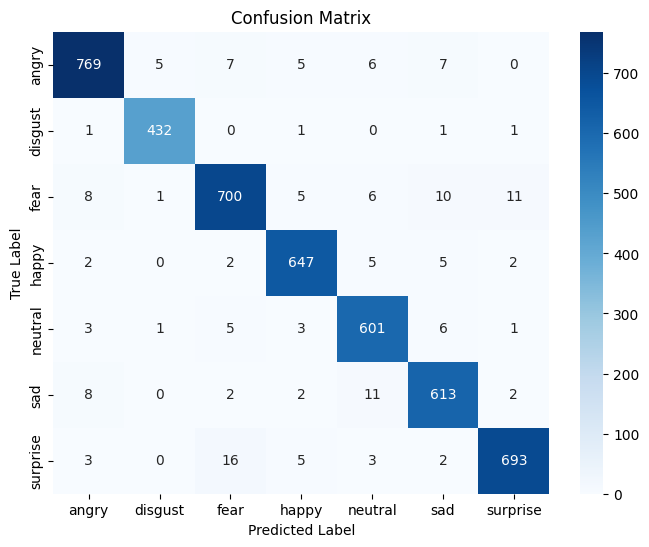

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
            yticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
